In [2]:
%matplotlib inline
import pandas as pd
from pandas import Series
import numpy as np
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Lambda
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import array
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support
import sqlite3
import keras
from scipy.special import softmax
from sklearn.metrics import accuracy_score

/Users/seungwooson/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
%%capture
from tqdm import tqdm_notebook
from tqdm import tnrange

In [4]:
df_final = pd.read_csv("data_cleaned_new_features.csv")

In [5]:
df_final['season'] = pd.factorize(df_final['season'])[0]

In [10]:
home_team_stats = ['home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
       'home_buildUpPlayPassing', 'home_chanceCreationPassing',
       'home_chanceCreationCrossing', 'home_chanceCreationShooting',
       'home_defencePressure', 'home_defenceAggression',
       'home_defenceTeamWidth']
away_team_stats = ['away_buildUpPlaySpeed', 'away_buildUpPlayDribbling',
       'away_buildUpPlayPassing', 'away_chanceCreationPassing',
       'away_chanceCreationCrossing', 'away_chanceCreationShooting',
       'away_defencePressure', 'away_defenceAggression',
       'away_defenceTeamWidth']
attributes_col = ['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
attributes_col.remove("preferred_foot")
attributes_col.remove("attacking_work_rate")
attributes_col.remove("defensive_work_rate")
def nameColumns(playerNum, homeOrAway):
    cols = attributes_col
    player_cols = []
    for col in cols:
        player_cols.append(homeOrAway + "_player_" + str(playerNum) + "_" + col)
    return player_cols
home_player_num = []
away_player_num = []
for i in range(1, 12):
    home_player_num.append(nameColumns(homeOrAway='home', playerNum=i))
    away_player_num.append(nameColumns(homeOrAway='away', playerNum=i))
home_player_num = np.array(home_player_num).flatten()
away_player_num = np.array(away_player_num).flatten()
home_record = ['home_win_record', 'home_loss_record', 'home_draw_record']
away_record = ['away_win_record', 'away_loss_record', 'away_draw_record']

In [9]:
from collections import Counter
home_players_y, away_players_y = [], []
for i in range(1, 12):
    home_players_y.append("home_player_Y"+str(i))
    away_players_y.append("away_player_Y"+str(i))
def formations(df):
    formation_dict = Counter(df)
    sorted_keys = sorted(formation_dict)
    formation = ''
    for key in sorted_keys[1:-1]:
        y = formation_dict[key]
        formation += '%d-' % y
    formation += '%d' % formation_dict[sorted_keys[-1]]
    return formation
df_final["home_formations"] = df_final[home_players_y].apply(formations, axis=1)
df_final["away_formations"] = df_final[away_players_y].apply(formations, axis=1)

In [11]:
desired_cols = np.concatenate((['season', 'home_formations'], home_team_stats, home_player_num, home_record, ['away_formations'], away_team_stats, away_player_num, away_record), axis=0)

In [12]:
X = df_final[desired_cols]
y = df_final['label_home']

In [13]:
X['home_formations'] = pd.factorize(X['home_formations'])[0]
X['away_formations'] = pd.factorize(X['away_formations'])[0]

/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [113]:
models_without_player_emb = []

In [114]:
from keras.models import Model
from keras.layers import Input, Dense, merge, Concatenate, Reshape, Dropout, BatchNormalization, PReLU
from keras.layers.embeddings import Embedding

#Add Player Stats 
player_input = Input(shape=(35,))
x = Dense(3, activation='relu')(player_input)
player_output = x
player_model = Model(player_input, player_output)

[home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11,\
away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11] \
= [Input(shape=(35,)) for i in range(22)]

players_input = [home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11,\
away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11]

players_encoded = [player_model(i) for i in players_input]

player_merged = merge(players_encoded, mode='concat')

#Add Categorical Column Embeddings
categorical_vars = ["home_formations", "season", "away_formations"]
for categorical_var in categorical_vars :
    model = Sequential()
    no_of_unique_cat  = X[categorical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    vocab  = no_of_unique_cat
    model.add(Embedding(vocab ,embedding_size, input_length = 1 ))
    model.add(Reshape(target_shape=(embedding_size,)))
    models_without_player_emb.append(model)
#Add rest numeric columns
numeric_len = len(X.columns) - len(categorical_vars) - len(home_player_num) - len(away_player_num)
model_numeric = Sequential()
model_numeric.add(Dense(16, input_shape=[numeric_len]))
inputs.append(model_numeric(Input(shape=(numeric_len,))))
models_without_player_emb.append(model_numeric)

model_without_player_emb = Sequential()
model_without_player_emb.add(Merge(models_without_player_emb, mode='concat'))

combinedInput = merge([model_without_player_emb.output, player_merged], mode='concat')


/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [127]:
xavier_init = glorot_normal(seed=35)
combined = Dense(27, activation=PReLU(), kernel_initializer=xavier_init)(combinedInput)
combined = BatchNormalization()(combined)
combined = Dense(9, activation=PReLU(),  kernel_initializer=xavier_init)(combined)
combined = BatchNormalization()(combined)
combined = Dense(3, activation='softmax')(combined)
full_model = Model(inputs=np.concatenate([model_without_player_emb.input, players_input], axis=0).tolist(), outputs=combined)

learning_rate = 1e-3
epochs = 100
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, decay=decay_rate)

full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [132]:
numeric_cols = [col for col in X.columns.values if col not in categorical_vars]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [134]:
X_train_inputs = []
X_train_inputs.append(X_train["home_formations"])
X_train_inputs.append(X_train["season"])
X_train_inputs.append(X_train["away_formations"])
X_train_inputs.append(X_train[np.concatenate((home_team_stats, home_record, away_team_stats, away_record), axis=0)])
for i in range(1, 12):
    X_train_inputs.append(X_train[nameColumns(homeOrAway="home", playerNum=i)])
for i in range(1, 12):
    X_train_inputs.append(X_train[nameColumns(homeOrAway="away", playerNum=i)])

In [135]:
X_test_inputs = []
X_test_inputs.append(X_test["home_formations"])
X_test_inputs.append(X_test["season"])
X_test_inputs.append(X_test["away_formations"])
X_test_inputs.append(X_test[np.concatenate((home_team_stats, home_record, away_team_stats, away_record), axis=0)])
for i in range(1, 12):
    X_test_inputs.append(X_test[nameColumns(homeOrAway="home", playerNum=i)])
for i in range(1, 12):
    X_test_inputs.append(X_test[nameColumns(homeOrAway="away", playerNum=i)])

In [136]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=5e-4)

In [137]:
history = full_model.fit(x=X_train_inputs, y=y_train_enc, batch_size=8, shuffle=True, epochs=100, 
          validation_data=(X_test_inputs, y_test_enc), callbacks=[reduce_lr])

Train on 18054 samples, validate on 2006 samples
Epoch 1/100
18054/18054 [==============================] - 16s 860us/step - loss: 1.0367 - acc: 0.4874 - val_loss: 0.9406 - val_acc: 0.5439
Epoch 2/100
18054/18054 [==============================] - 14s 760us/step - loss: 0.9454 - acc: 0.5525 - val_loss: 0.9305 - val_acc: 0.5439
Epoch 3/100
18054/18054 [==============================] - 12s 666us/step - loss: 0.9349 - acc: 0.5611 - val_loss: 0.9363 - val_acc: 0.5538
Epoch 4/100
18054/18054 [==============================] - 12s 663us/step - loss: 0.9318 - acc: 0.5598 - val_loss: 0.9253 - val_acc: 0.5568
Epoch 5/100
18054/18054 [==============================] - 12s 677us/step - loss: 0.9312 - acc: 0.5605 - val_loss: 0.9280 - val_acc: 0.5508
Epoch 6/100
18054/18054 [==============================] - 12s 683us/step - loss: 0.9303 - acc: 0.5610 - val_loss: 0.9253 - val_acc: 0.5608
Epoch 7/100
18054/18054 [==============================] - 12s 657us/step - loss: 0.9278 - acc: 0.5626 - val_lo

18054/18054 [==============================] - 12s 669us/step - loss: 0.8757 - acc: 0.5973 - val_loss: 0.9167 - val_acc: 0.5733
Epoch 58/100
18054/18054 [==============================] - 12s 643us/step - loss: 0.8783 - acc: 0.5912 - val_loss: 0.9218 - val_acc: 0.5713
Epoch 59/100
18054/18054 [==============================] - 12s 663us/step - loss: 0.8732 - acc: 0.5996 - val_loss: 0.9178 - val_acc: 0.5748
Epoch 60/100
18054/18054 [==============================] - 12s 639us/step - loss: 0.8738 - acc: 0.5960 - val_loss: 0.9202 - val_acc: 0.5743
Epoch 61/100
18054/18054 [==============================] - 11s 630us/step - loss: 0.8744 - acc: 0.5999 - val_loss: 0.9157 - val_acc: 0.5788
Epoch 62/100
18054/18054 [==============================] - 12s 656us/step - loss: 0.8767 - acc: 0.5995 - val_loss: 0.9215 - val_acc: 0.5723
Epoch 63/100
18054/18054 [==============================] - 12s 652us/step - loss: 0.8723 - acc: 0.5995 - val_loss: 0.9218 - val_acc: 0.5713
Epoch 64/100
18054/18054 [

dict_keys(['loss', 'val_acc', 'acc', 'lr', 'val_loss'])


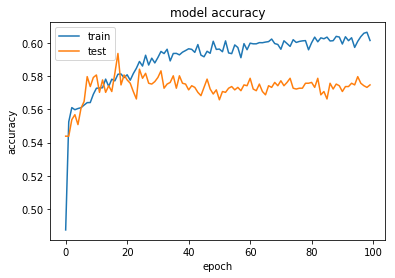

In [138]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

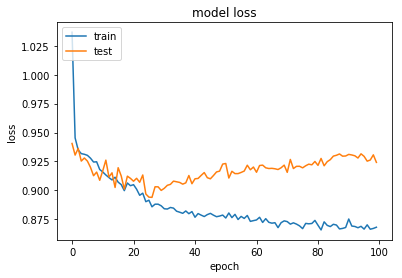

In [139]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [140]:
full_model.evaluate(X_test_inputs, y_test_enc)

2006/2006 [==============================] - 0s 92us/step


[0.9242095426690662, 0.5747756730404832]